In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
stix = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/STIXGeneral.ttf')
mpl.rcParams['font.serif']=stix.get_name()
mpl.rcParams['mathtext.fontset']='stix'
mpl.rc('axes', unicode_minus=False)

In [4]:
# colour maps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
color_R=['#56B4E9','#E69F00','#009E72','#F0E442','#0072B2','#D55E00','#CC79A7'] # Okabe&Ito (ish)

In [5]:
N_param_vals=5
cosmo_params_dict={
    'omega_b': np.linspace(0.020,0.030,N_param_vals),
    'omega_cdm': np.linspace(0.08,0.14,N_param_vals), 
    'h': np.linspace(0.66,0.68,N_param_vals), 
    'tau_reio': np.linspace(0.08,0.12,N_param_vals),
    'n_s': np.linspace(0.95,0.97,N_param_vals), 
    'ln10^{10}A_s': np.linspace(3.05,3.15,N_param_vals),
    'cmin': np.linspace(2.5,2.7,N_param_vals),
    'eta_0': np.linspace(0.6,0.8,N_param_vals), 
    'z': np.linspace(0.0,2.0,N_param_vals)
}

In [6]:
emulator = CPJ(probe='mpk_nonlin')
emulator_predictions = emulator.predict(cosmo_params_dict)

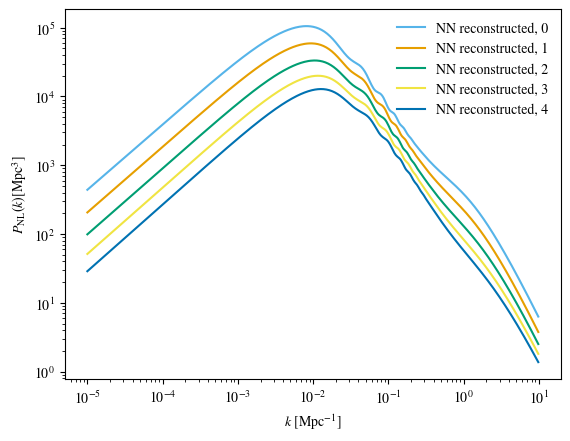

In [7]:
# and finally plot
k_range = emulator.modes
fig, ax = plt.subplots()
pred = emulator_predictions
for i in range(N_param_vals):
    ax.loglog(k_range, pred[i], color_R[i], label = 'NN reconstructed, %s' %i, linestyle='-')
    ax.set_xlabel('$k$ [Mpc$^{-1}]$')
    ax.set_ylabel('$P_{\mathrm{NL}}(k) [\mathrm{Mpc}^3]$')

ax.legend(frameon=False,loc=1)

# latin hypercube

In [88]:
cosmo_params_dict={
    'omega_b': np.array([0.025]),
    'omega_cdm': np.array([0.11]), 
    'h': np.array([0.6711]), 
    'n_s': np.array([0.9624]), 
    'ln10^{10}A_s': np.array([3.1]),
    'cmin': np.array([2.6]),
    'eta_0': np.array([0.7]), 
    'z': np.array([0.0])
}

In [89]:
bounds_dict={
    'omega_b': [0.020,0.030],
    'omega_cdm': [0.08,0.14], 
    'h': [0.66,0.68], 
    'tau_reio': [0.08,0.12],
    'n_s': [0.95,0.97], 
    'ln10^{10}A_s': [3.05,3.15],
    'cmin': [2.5,2.7],
    'eta_0': [0.6,0.8], 
    'z': [0.0,0.0]
}




In [91]:
from scipy.stats import qmc
def HypercubeGo(cosmo_params_dict,bounds_dict,N_samples):
    d = len(cosmo_params_dict.items()) # dimension of the parameter space.
    sampler = qmc.LatinHypercube(d)
    sample = sampler.random(n=N_samples)
    # change limits for each param
    for i,item in enumerate(cosmo_params_dict.items()):
        param=item[0]
        lower_bound,upper_bound=bounds_dict[param]
        dlt=upper_bound-lower_bound
        sample[:,i]*=dlt
        sample[:,i]+=lower_bound
    return sample

def MPkHypercube(i,sample):
    params=sample[i,:]
    emulator = CPJ(probe='mpk_nonlin')
    pred = emulator.predict(params)
    k_range = emulator.modes
    return k_range,pred,params
    
    


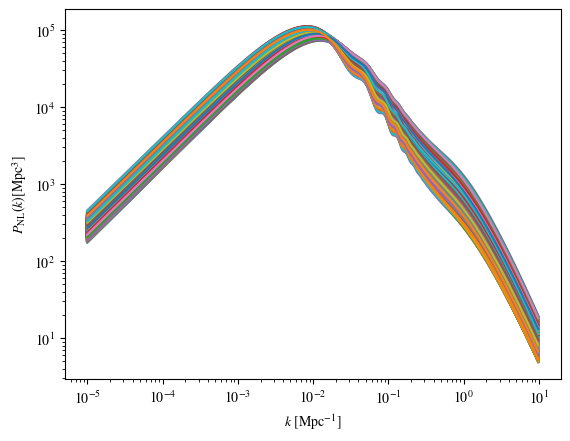

In [120]:
import os
save_Pks=True
N_samples=4012
N_params=8
sample=HypercubeGo(cosmo_params_dict,bounds_dict,N_samples)


fig, ax = plt.subplots()
for i in range(N_samples):
    k_range,pred,params=MPkHypercube(i,sample)
    if save_Pks==True:
        if i==0:
            Pks=np.zeros((len(k_range),N_samples))
            params_all=np.zeros((N_params,N_samples))
        Pks[:,i]=pred
        params_all[:,i]=params
        folder='predicted_mPks_2/'
    ax.loglog(k_range, pred, label = 'NN reconstructed, %s' %i, linestyle='-')
    ax.set_xlabel('$k$ [Mpc$^{-1}]$')
    ax.set_ylabel('$P_{\mathrm{NL}}(k) [\mathrm{Mpc}^3]$')
if save_Pks==True:
    if not os.path.exists(folder): os.makedirs(folder)
    np.savetxt(folder+'predicted_mPks_%ssamples.dat' %N_samples,Pks)
    np.savetxt(folder+'params_for_predicted_mPks_%ssamples.dat' %N_samples,params_all)


    

# ax.legend(frameon=False,loc=1)



# compression CCA

In [34]:
def Cov_Matrix(Pks,N_sims=1000): 
	data_vector=np.empty([0,N_sims])
	data_vector=np.concatenate((data_vector,Pks[:,:N_sims]))
	cov_matrix=np.cov(data_vector)
	return(cov_matrix)

In [122]:
Pks=np.loadtxt('predicted_mPks/predicted_mPks_4012samples.dat')
params_all=np.loadtxt('predicted_mPks/params_for_predicted_mPks_4012samples.dat')[:-1,:]

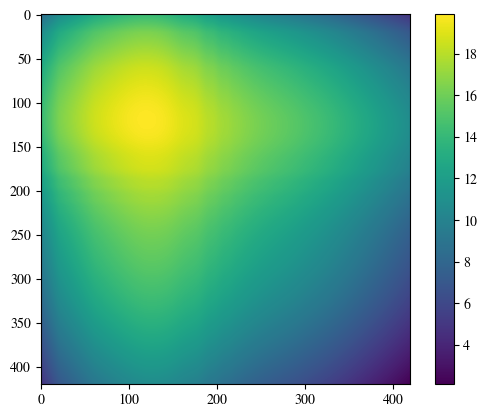

In [56]:
plt.imshow(np.log(abs(Cov_Matrix(Pks,4012))))
plt.colorbar()

In [96]:
np.shape(params_all)

(7, 4012)

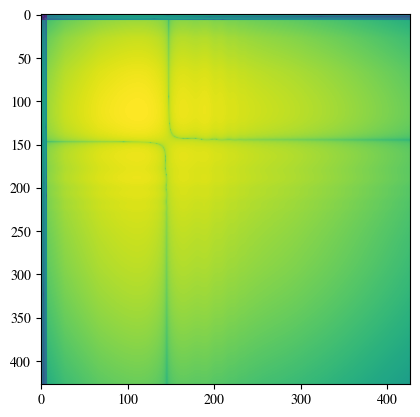

In [124]:
import scipy
N_params=7

mat=np.vstack((params_all,Pks))
cov=np.cov(mat)
# cov=np.cov(params_all,Pks)
plt.imshow(np.log(abs(cov)))
cp = cov[:N_params,:N_params]
cd = cov[N_params:,N_params:]
cpd = cov[:N_params,N_params:]

cl = cpd.T@np.linalg.inv(cp)@cpd

evals, evecs = scipy.linalg.eigh(cd, cd - cl)

evals = evals[::-1][:N_params]
evecs = evecs[:,::-1][:,:N_params]

dv_LFI=np.loadtxt('predicted_mPks_2/predicted_mPks_4012samples.dat').T

compressed_dv = dv_LFI@evecs



In [125]:
np.shape(compressed_dv)

(4012, 7)